In [1]:
import os
from itertools import product

import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
CSV_PATH = "/home/28i_mel@lab.graphicon.ru/mnt/dione/28i_mel/Linearity-results/"
get_base_line = lambda dataset, iter: f"{dataset}_resnet101+relu_PGD={iter}.csv"
sns.set_color_codes('deep')
sns.set_theme()

In [3]:
activations = [
    "relu",
    "Frelu_elu",
]
archs = [
    "resnet101",
    "vonenet50",
]
prunes = [ 
    {
        'percent': .0,
        'method': '',
    }, 
    {
        'percent': .1,
        'method': 'pls',
    },
    {
        'percent': .1,
        'method': 'l1',
    },
    {
        'percent': .1,
        'method': 'l2',
    }
]
cayley = [
    
    False,
    True,
]
cayley_pool = [
    True,
    False
]
cayley_pair = [
    
    False,
    True,
]
gradnorm = [
    
    False,
    True,
]
resizers = [
    True,
    False
]

datasets = ["KonIQ-10k", "NIPS"]

In [4]:
available_results = os.listdir(CSV_PATH)

In [5]:
class Scores:
    def __init__(self, **kwargs):
        self.nips_df, self.koniq_df = kwargs.get("nips_df", None), kwargs.get("koniq_df", None)
        self.iters = kwargs.get("iters", 1)
    def fit(self, col):
        if self.nips_df is not None:
            # self.scaler_nips = MinMaxScaler()
            # self.scaler_nips.fit(self.nips_df[col].to_numpy().reshape(-1,1))
            self.nips_min = self.nips_df[col].min()
            self.nips_max = self.nips_df[col].max()
        if self.koniq_df is not None:
            # self.scaler_koniq = MinMaxScaler()
            # self.scaler_koniq.fit(self.koniq_df[col].to_numpy().reshape(-1,1))
            self.koniq_min = self.koniq_df[col].min()
            self.koniq_max = self.koniq_df[col].max()


    def scale(self, clear_val, attacked_val, dataset):
        if dataset=='NIPS':
            # scaled_clear_val = self.scaler_nips.transform(clear_val.reshape(-1,1))
            # scaled_attacked_val = self.scaler_nips.transform(attacked_val.reshape(-1,1))
            scaled_clear_val = ((clear_val - self.nips_min)/(self.nips_max - self.nips_min))
            scaled_attacked_val = ((attacked_val - self.nips_min)/(self.nips_max - self.nips_min))
        elif dataset=='KonIQ-10k':
            # scaled_clear_val = self.scaler_koniq.transform(clear_val.reshape(-1, 1))
            # scaled_attacked_val = self.scaler_koniq.transform(attacked_val.reshape(-1,1))
            scaled_clear_val = ((clear_val - self.koniq_min)/(self.koniq_max - self.koniq_min))
            scaled_attacked_val = ((attacked_val - self.koniq_min)/(self.koniq_max - self.koniq_min))
        return scaled_clear_val, scaled_attacked_val
    
    def get_abs_gain(self, clear_val, attacked_val, dataset='NIPS'):
        if isinstance(clear_val, pd.DataFrame) or isinstance(clear_val, pd.Series):
            clear_val = clear_val.to_numpy()
        if isinstance(attacked_val, pd.DataFrame) or isinstance(attacked_val, pd.Series):
            attacked_val = attacked_val.to_numpy()
        
        scaled_clear_val, scaled_attacked_val = self.scale(clear_val, attacked_val, dataset)
        # print(scaled_clear_val.min(), scaled_clear_val.max())
        # print(scaled_attacked_val, scaled_clear_val)
        return (scaled_attacked_val - scaled_clear_val).mean()

    def get_r_score(self, clear_val, attacked_val, dataset='NIPS'):
        if isinstance(clear_val, pd.DataFrame) or isinstance(clear_val, pd.Series):
            clear_val = clear_val.to_numpy()
        if isinstance(attacked_val, pd.DataFrame) or isinstance(attacked_val, pd.Series):
            attacked_val = attacked_val.to_numpy()
        scaled_clear_val, scaled_attacked_val = self.scale(clear_val, attacked_val, dataset)
        beta1 = max(scaled_attacked_val)
        beta0 = min(scaled_clear_val)
        # print(min(scaled_attacked_val), max(scaled_attacked_val), min(scaled_clear_val), max(scaled_clear_val))
        return np.mean(
            np.log10(
                np.maximum(beta1-scaled_attacked_val, scaled_clear_val-beta0)/np.abs(scaled_attacked_val-scaled_clear_val)
                )
            )

In [6]:
def draw_plot(iterations=1, ax_rows=10, ax_cols=2, figsize=(14,50), wsapce=0.2, hspace=0.3):
    epsilons = [ 2, 4, 6, 8, 10 ]
    attack_type = "PGD"

    baseline_df_nips = pd.read_csv(os.path.join(CSV_PATH, get_base_line('NIPS', iterations)))
    baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, get_base_line('KonIQ-10k', iterations)))
    scores = Scores(nips_df=baseline_df_nips, koniq_df=baseline_df_koniq)
    scores.fit(col='clear_val')

    baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
    for i, df in enumerate((baseline_df_koniq, baseline_df_nips)):
        for eps in epsilons:
            baseLine.loc[len(baseLine)] = {
                                        'eps': f"{eps}/255",
                                        'abs_gain': 
                                            scores.get_abs_gain(df['clear_val'], 
                                                                df[f'attacked_val_eps={eps}'],
                                                                dataset=datasets[i]),
                                        'r_score': 
                                            scores.get_r_score(df['clear_val'], 
                                                            df[f'attacked_val_eps={eps}'], 
                                                            dataset=datasets[i]),
                                        'dataset': datasets[i]
                                        }

    fig, axis = plt.subplots(ax_rows, ax_cols, figsize=figsize, sharey=False)
    plt.subplots_adjust(wspace=wsapce, hspace=hspace)
    # axis = axis.flatten()
    plot_idx = 0

    arch_title = None

    for (
        # dataset,
        is_cayley, 
        is_cayley_pool, 
        is_cayley_pair,
        is_gradnorm_regularization,
        prune,
        arch,
        activation,
        is_resize,
        ) in product(
                        # datasets,
                        cayley, 
                        cayley_pool, 
                        cayley_pair, 
                        gradnorm,
                        prunes,
                        archs,
                        activations,
                        resizers,
                        ):
        data = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
        for dataset in datasets:
            cl = f'+cayley' if is_cayley else ''
            clp = f'+cayley_pool' if is_cayley_pool else ''
            cp = f'+cayley_pair' if is_cayley_pair else ''
            gr = f'+gr' if is_gradnorm_regularization else ''
            resize = f'+resize=498x664' if is_resize else ''
            prune_status = f"+{prune['percent']}_{prune['method']}" if prune['percent'] else ''
            arch_status = f'{arch}{cl}{clp}{cp}{gr}{prune_status}+{activation}'
            path = "{}_{}_{}={}{}.csv".format(
                                            dataset,
                                            arch_status,
                                            attack_type,
                                            iterations,
                                            resize
                                            )
            
            if path not in available_results:
                break
            
            path = os.path.join(CSV_PATH, path)
            df = pd.read_csv(path, index_col=False)
            
            arch_title = f"{arch_status}{resize} {attack_type}-{iterations}"
            for eps in epsilons:
                data.loc[len(data)] = {
                        'eps': f'{int(eps)}/255',
                        'abs_gain': scores.get_abs_gain(df['clear_val'], 
                                                        df[f'attacked_val_eps={eps}'],
                                                        dataset=dataset),
                        'r_score': scores.get_r_score(df['clear_val'], 
                                                    df[f'attacked_val_eps={eps}'], 
                                                    dataset=dataset),
                        'dataset': dataset,
                }

        
        if len(data) > 0:
            sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
                        legend='full', hue='dataset', ax=axis[plot_idx][0]
                        )
            sns.lineplot(data=data, x='eps', y='abs_gain', 
                        legend="full", hue="dataset", ax=axis[plot_idx][0])
            
            sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
                        legend='full', hue='dataset', ax=axis[plot_idx][1]
                        )
            sns.lineplot(data=data, x='eps', y='r_score', 
                        legend="full", hue="dataset", ax=axis[plot_idx][1])
            axis[plot_idx][0].set_title(arch_title)
            axis[plot_idx][1].set_title(arch_title)
            plot_idx += 1

    plt.show()

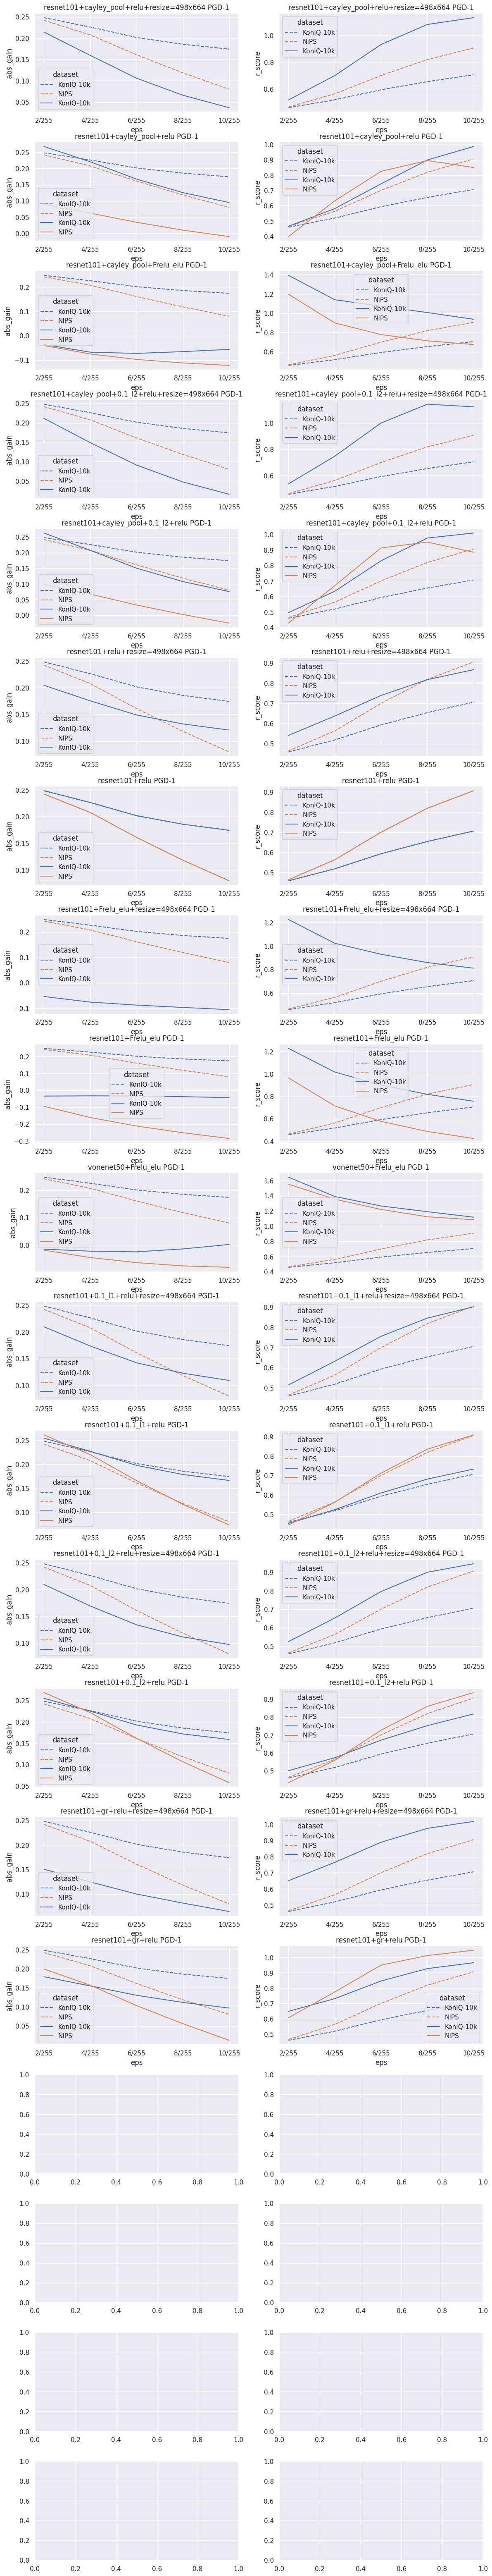

In [7]:
draw_plot(iterations=1, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3)

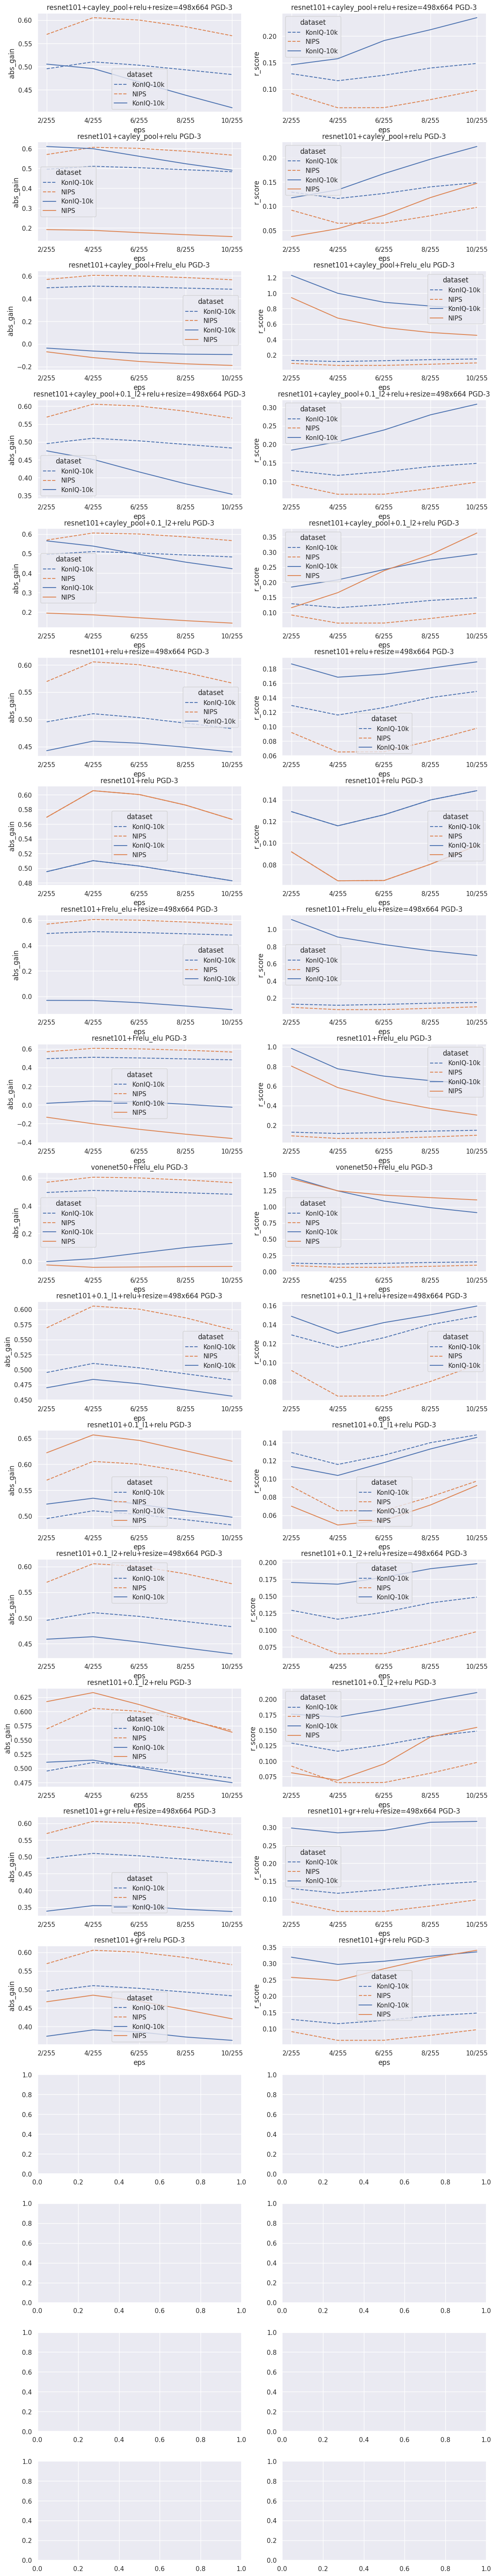

In [8]:
draw_plot(iterations=3, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3)

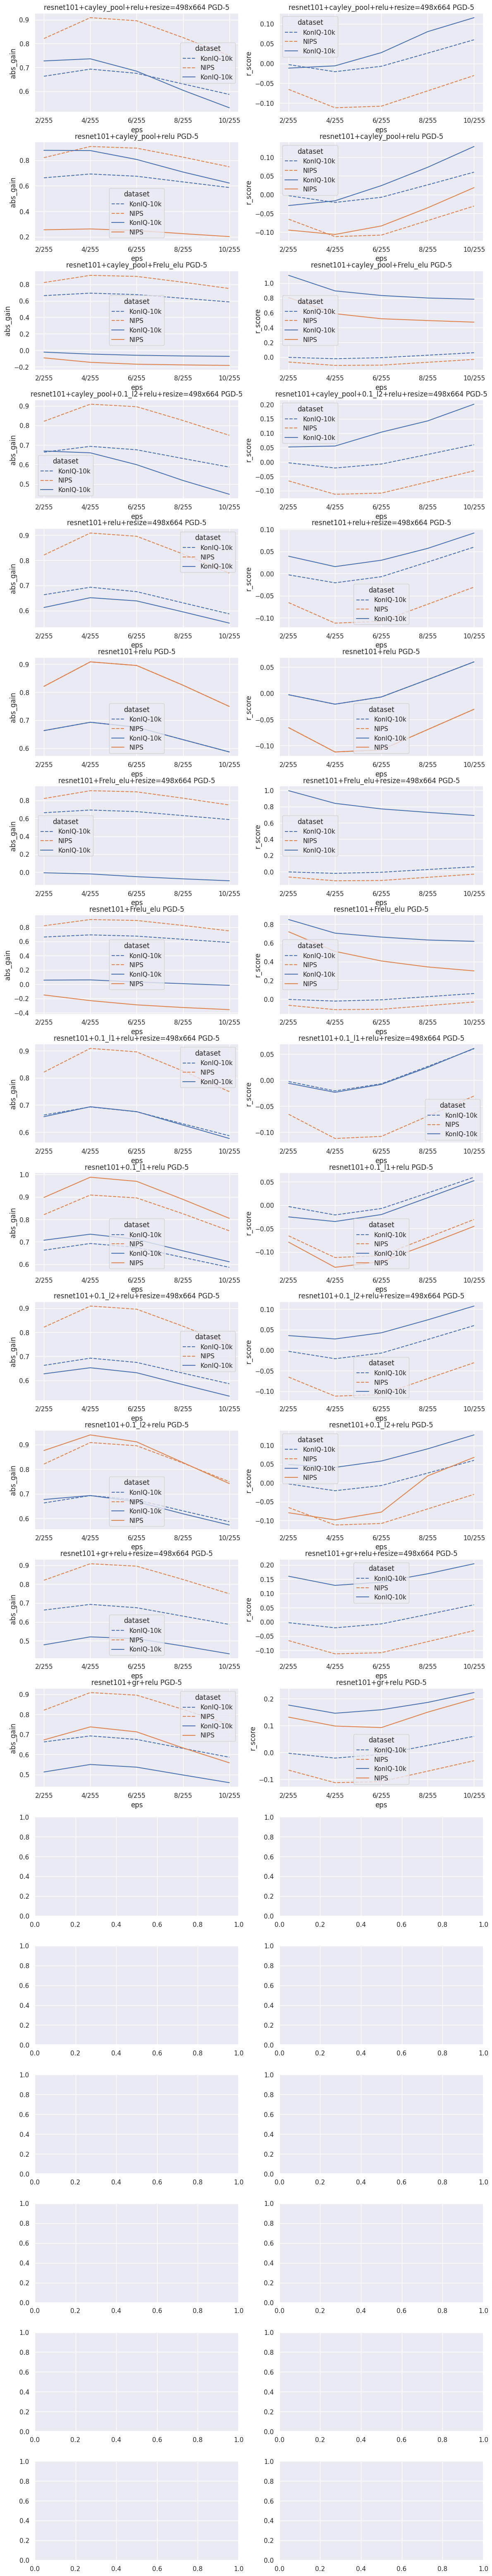

In [9]:
draw_plot(iterations=5, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3)

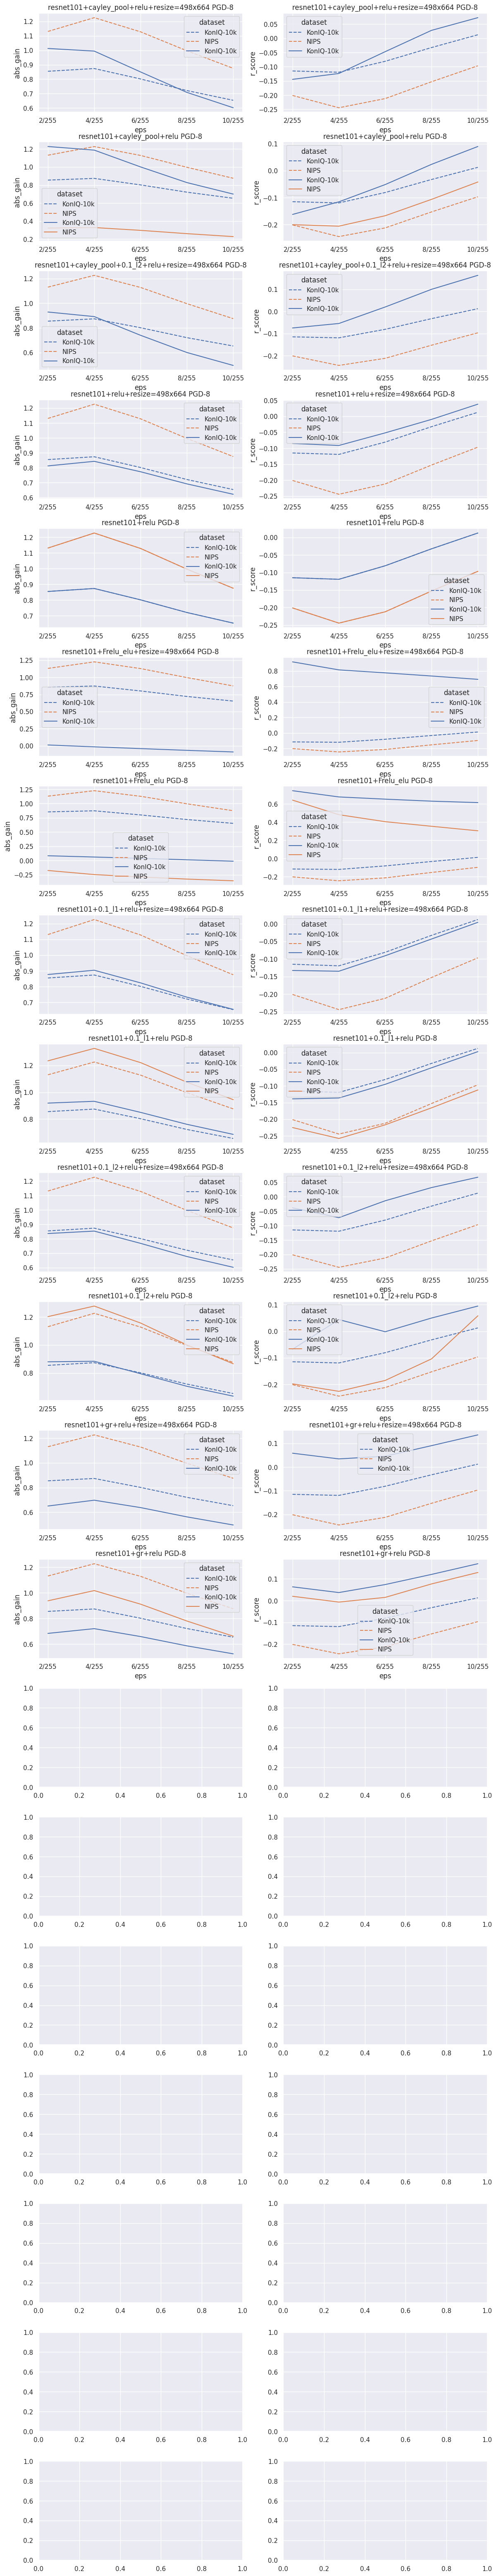

In [10]:
draw_plot(iterations=8, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3)

<Axes: xlabel='eps', ylabel='r_score'>

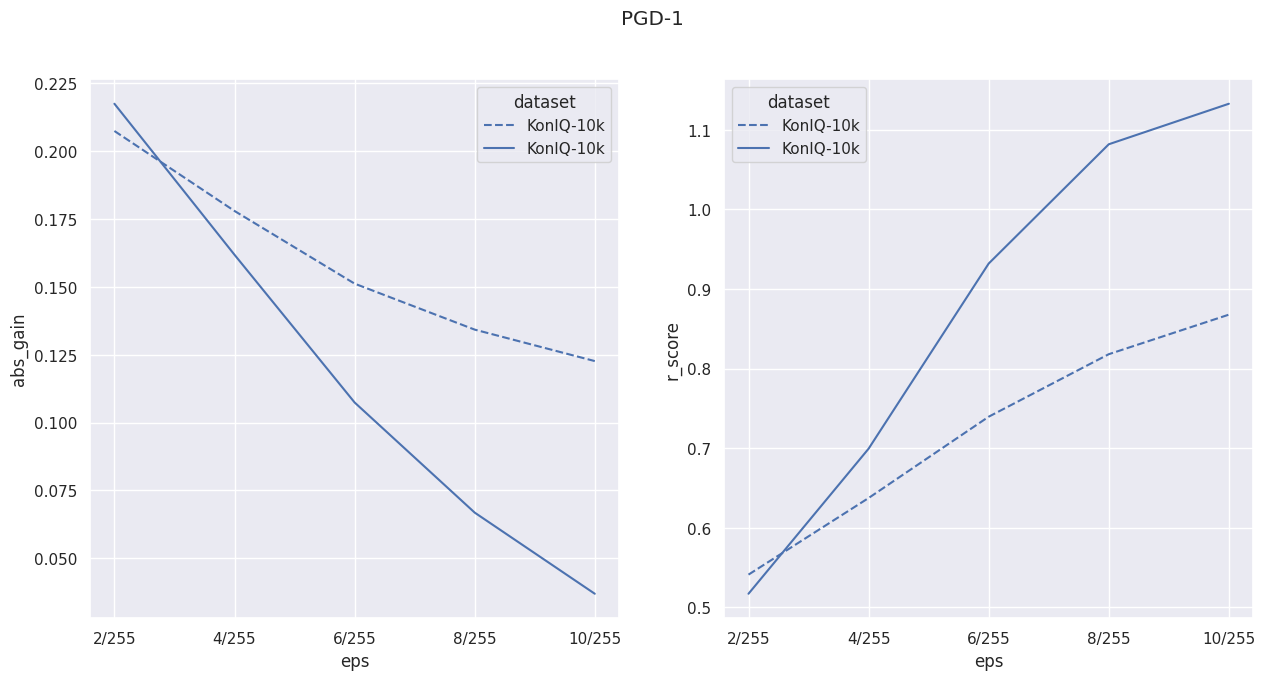

In [162]:
itr = 1
epsilons = [2, 4, 6, 8, 10]
path_resize = f'KonIQ-10k_resnet101+relu_PGD={itr}+resize=498x664.csv'
path_resize_clp = f'KonIQ-10k_resnet101+cayley_pool+relu_PGD={itr}+resize=498x664.csv'

baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for eps in epsilons:
    baseLine.loc[len(baseLine)] = {
                                'eps': f"{eps}/255",
                                'abs_gain': 
                                    scores.get_abs_gain(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'],
                                                        dataset='KonIQ-10k'),
                                'r_score': 
                                    scores.get_r_score(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'], 
                                                        dataset='KonIQ-10k'),
                                'dataset': 'KonIQ-10k'
                                }

modif = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize_clp))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

for eps in epsilons:
    modif.loc[len(modif)] = {
                            'eps': f"{eps}/255",
                            'abs_gain': 
                                scores.get_abs_gain(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'],
                                                    dataset='KonIQ-10k'),
                            'r_score': 
                                scores.get_r_score(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'], 
                                                    dataset='KonIQ-10k'),
                            'dataset': 'KonIQ-10k'
                            }
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle(f'PGD-{itr}')
sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[0])
sns.lineplot(data=modif, x='eps', y='abs_gain', 
            legend="full", hue="dataset", ax=ax[0])

sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[1])
sns.lineplot(data=modif, x='eps', y='r_score', 
            legend="full", hue="dataset", ax=ax[1])

<Axes: xlabel='eps', ylabel='r_score'>

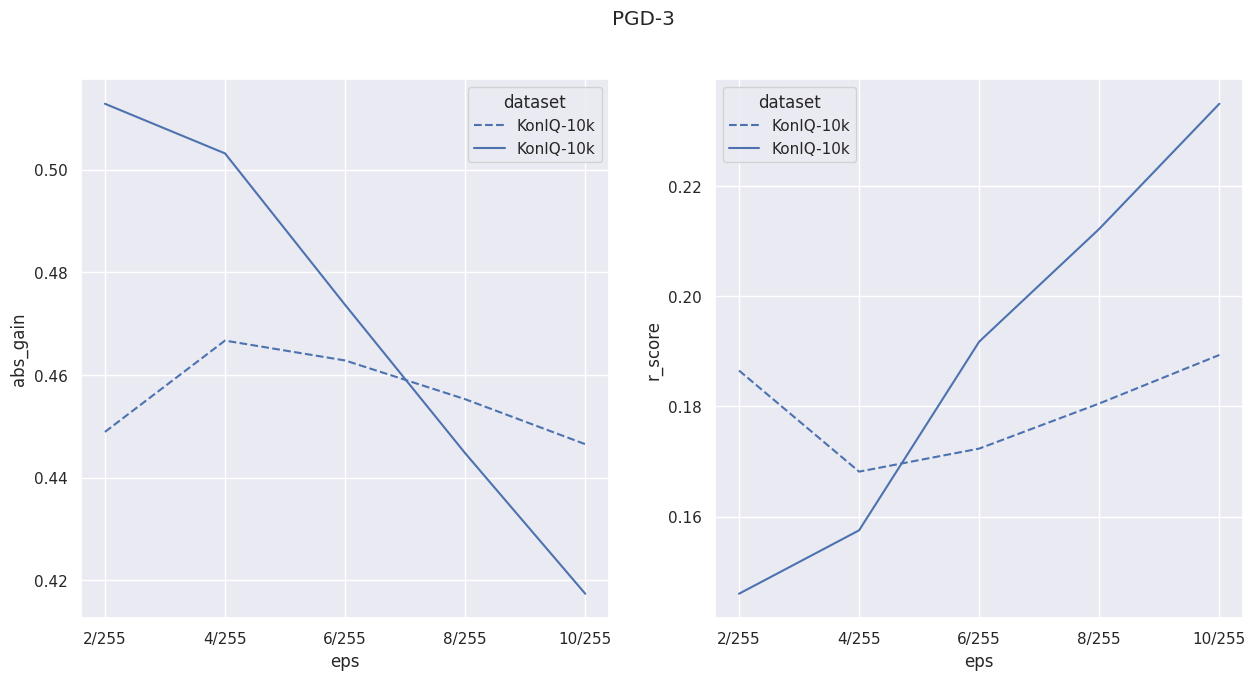

In [163]:
itr = 3
epsilons = [2, 4, 6, 8, 10]
path_resize = f'KonIQ-10k_resnet101+relu_PGD={itr}+resize=498x664.csv'
path_resize_clp = f'KonIQ-10k_resnet101+cayley_pool+relu_PGD={itr}+resize=498x664.csv'

baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for eps in epsilons:
    baseLine.loc[len(baseLine)] = {
                                'eps': f"{eps}/255",
                                'abs_gain': 
                                    scores.get_abs_gain(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'],
                                                        dataset='KonIQ-10k'),
                                'r_score': 
                                    scores.get_r_score(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'], 
                                                        dataset='KonIQ-10k'),
                                'dataset': 'KonIQ-10k'
                                }

modif = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize_clp))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

for eps in epsilons:
    modif.loc[len(modif)] = {
                            'eps': f"{eps}/255",
                            'abs_gain': 
                                scores.get_abs_gain(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'],
                                                    dataset='KonIQ-10k'),
                            'r_score': 
                                scores.get_r_score(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'], 
                                                    dataset='KonIQ-10k'),
                            'dataset': 'KonIQ-10k'
                            }
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle(f'PGD-{itr}')
sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[0])
sns.lineplot(data=modif, x='eps', y='abs_gain', 
            legend="full", hue="dataset", ax=ax[0])

sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[1])
sns.lineplot(data=modif, x='eps', y='r_score', 
            legend="full", hue="dataset", ax=ax[1])

<Axes: xlabel='eps', ylabel='r_score'>

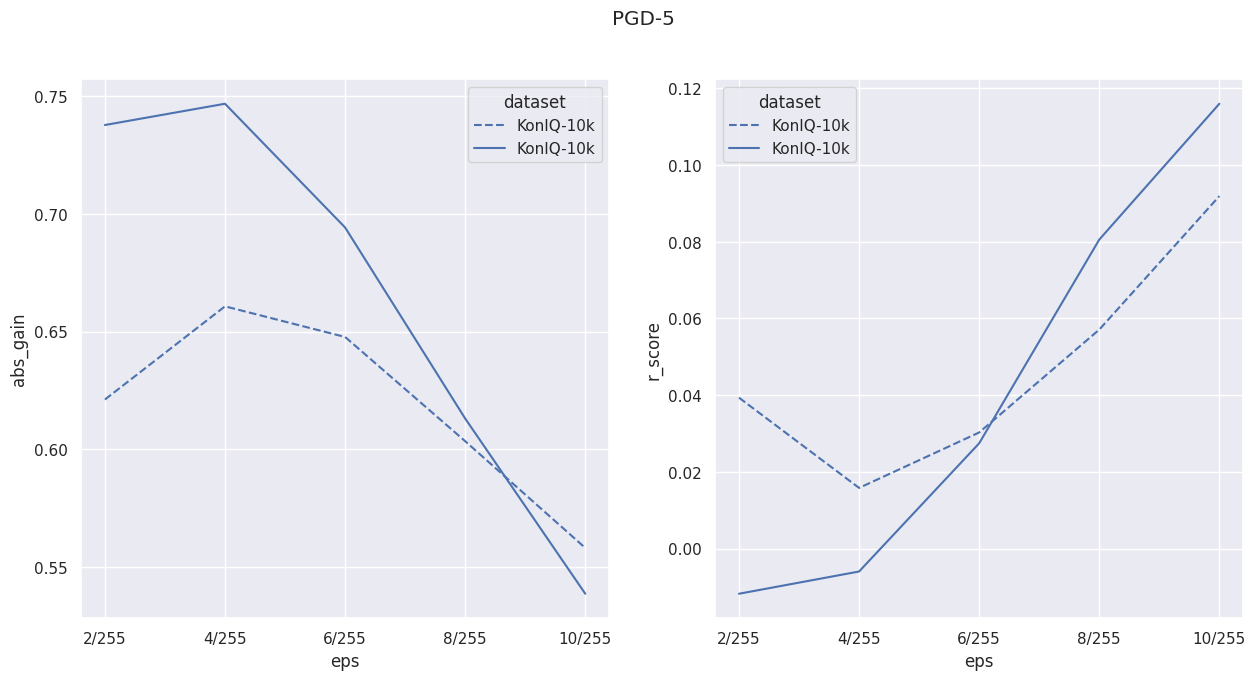

In [164]:
itr = 5
epsilons = [2, 4, 6, 8, 10]
path_resize = f'KonIQ-10k_resnet101+relu_PGD={itr}+resize=498x664.csv'
path_resize_clp = f'KonIQ-10k_resnet101+cayley_pool+relu_PGD={itr}+resize=498x664.csv'

baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for eps in epsilons:
    baseLine.loc[len(baseLine)] = {
                                'eps': f"{eps}/255",
                                'abs_gain': 
                                    scores.get_abs_gain(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'],
                                                        dataset='KonIQ-10k'),
                                'r_score': 
                                    scores.get_r_score(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'], 
                                                        dataset='KonIQ-10k'),
                                'dataset': 'KonIQ-10k'
                                }

modif = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize_clp))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

for eps in epsilons:
    modif.loc[len(modif)] = {
                            'eps': f"{eps}/255",
                            'abs_gain': 
                                scores.get_abs_gain(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'],
                                                    dataset='KonIQ-10k'),
                            'r_score': 
                                scores.get_r_score(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'], 
                                                    dataset='KonIQ-10k'),
                            'dataset': 'KonIQ-10k'
                            }
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle(f'PGD-{itr}')
sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[0])
sns.lineplot(data=modif, x='eps', y='abs_gain', 
            legend="full", hue="dataset", ax=ax[0])

sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[1])
sns.lineplot(data=modif, x='eps', y='r_score', 
            legend="full", hue="dataset", ax=ax[1])

<Axes: xlabel='eps', ylabel='r_score'>

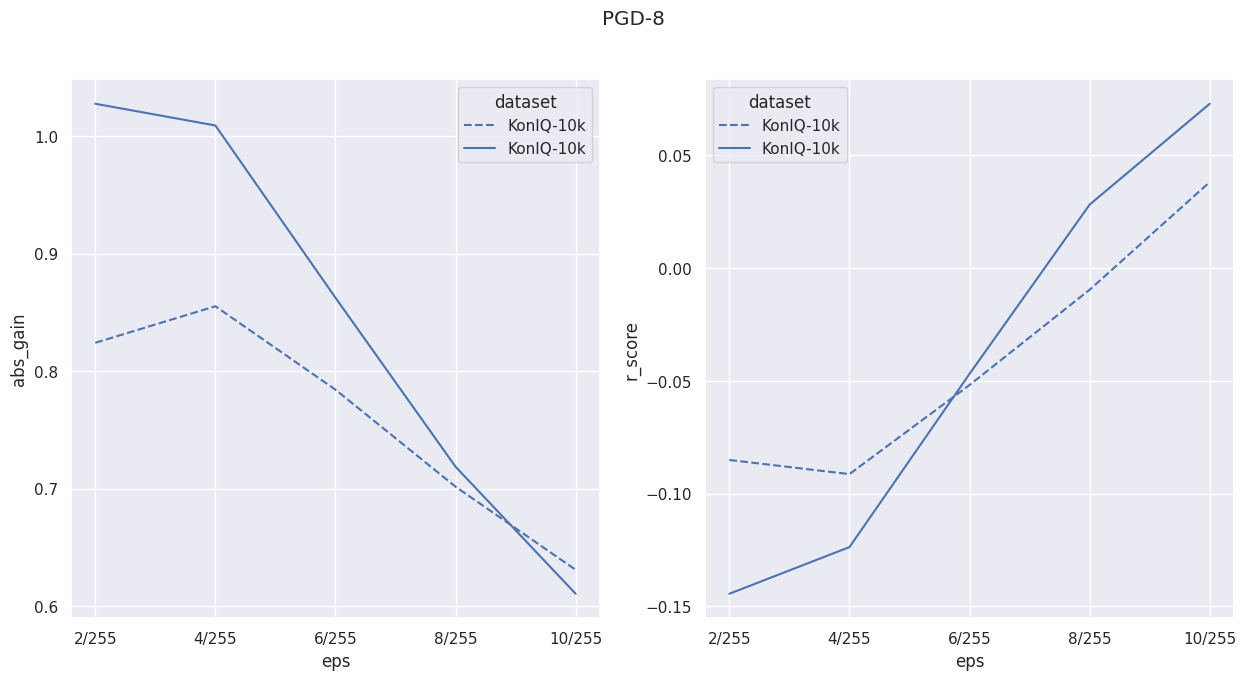

In [165]:
itr = 8
epsilons = [2, 4, 6, 8, 10]
path_resize = f'KonIQ-10k_resnet101+relu_PGD={itr}+resize=498x664.csv'
path_resize_clp = f'KonIQ-10k_resnet101+cayley_pool+relu_PGD={itr}+resize=498x664.csv'

baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for eps in epsilons:
    baseLine.loc[len(baseLine)] = {
                                'eps': f"{eps}/255",
                                'abs_gain': 
                                    scores.get_abs_gain(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'],
                                                        dataset='KonIQ-10k'),
                                'r_score': 
                                    scores.get_r_score(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'], 
                                                        dataset='KonIQ-10k'),
                                'dataset': 'KonIQ-10k'
                                }

modif = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize_clp))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

for eps in epsilons:
    modif.loc[len(modif)] = {
                            'eps': f"{eps}/255",
                            'abs_gain': 
                                scores.get_abs_gain(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'],
                                                    dataset='KonIQ-10k'),
                            'r_score': 
                                scores.get_r_score(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'], 
                                                    dataset='KonIQ-10k'),
                            'dataset': 'KonIQ-10k'
                            }
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle(f'PGD-{itr}')
sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[0])
sns.lineplot(data=modif, x='eps', y='abs_gain', 
            legend="full", hue="dataset", ax=ax[0])

sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[1])
sns.lineplot(data=modif, x='eps', y='r_score', 
            legend="full", hue="dataset", ax=ax[1])